In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

df_customers = pd.read_csv('one_day_simulation.csv',parse_dates=True)
df_customers.head(90)

,time,location,customer_id
0,2025-03-02 07:25:00,entrance,1
1,2025-03-02 07:26:00,drinks,1
2,2025-03-02 07:27:00,drinks,1
3,2025-03-02 07:28:00,spices,1
4,2025-03-02 07:29:00,spices,1
...,...,...,...
85,2025-03-02 08:08:00,fruit,11
86,2025-03-02 08:09:00,fruit,11
87,2025-03-02 08:10:00,fruit,11
88,2025-03-02 08:11:00,fruit,11


In [8]:
df_customers['time']= pd.to_datetime(df_customers['time'])
df_customers['arrival_time']=df_customers.groupby('customer_id')['time'].transform(min)
df_customers['leaving_time']=df_customers.groupby('customer_id')['time'].transform(max)
#Hour label to plot
df_customers['hour']=df_customers['time'].dt.hour
#Total time spent in the supermarker

# print(df_customers['total_time'])
df_customers['total_time'] = df_customers['leaving_time'] - df_customers['arrival_time']
# df_customers['total_time'] = pd.to_datetime(df_customers['total_time']).dt.hour * 60 + pd.to_datetime(df_customers['total_time']).dt.minute
df_customers['total_time'] = df_customers['total_time'].dt.total_seconds() // 60

#Add a price column to map location with price of products 
df_customers['price']=df_customers['location']
df_customers.price = df_customers.price.map( {'entrance':0 ,'checkout':0,'fruit':4,'spices':3,'dairy':5,'drinks':6} )
df_customers.sort_values(by=['time'],inplace=True)
df_customers.head()

C:\Users\PMLS\AppData\Local\Temp\ipykernel_9260\4160812696.py:2: FutureWarning: The provided callable <built-in function min> is currently using SeriesGroupBy.min. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "min" instead.
  df_customers['arrival_time']=df_customers.groupby('customer_id')['time'].transform(min)
C:\Users\PMLS\AppData\Local\Temp\ipykernel_9260\4160812696.py:3: FutureWarning: The provided callable <built-in function max> is currently using SeriesGroupBy.max. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "max" instead.
  df_customers['leaving_time']=df_customers.groupby('customer_id')['time'].transform(max)


,time,location,customer_id,arrival_time,leaving_time,hour,total_time,price
0,2025-03-02 07:25:00,entrance,1,2025-03-02 07:25:00,2025-03-02 07:37:00,7,12.0,0
1,2025-03-02 07:26:00,drinks,1,2025-03-02 07:25:00,2025-03-02 07:37:00,7,12.0,6
13,2025-03-02 07:26:00,entrance,2,2025-03-02 07:26:00,2025-03-02 07:37:00,7,11.0,0
14,2025-03-02 07:27:00,drinks,2,2025-03-02 07:26:00,2025-03-02 07:37:00,7,11.0,6
25,2025-03-02 07:27:00,entrance,3,2025-03-02 07:27:00,2025-03-02 07:38:00,7,11.0,0


# How many new entrance per hour?

Text(30.500617283950625, 0.5, 'Number of new entrance')

<Figure size 800x500 with 0 Axes>

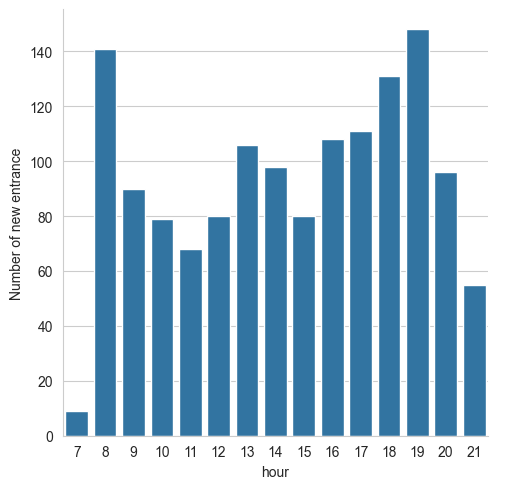

In [9]:
#Nb of customer at entrance per hour
plt.figure(figsize=(8,5))
df_plot_entrance = df_customers.loc[(df_customers['location'] == 'entrance') ,:].copy()
df_plot_entrance = df_plot_entrance.groupby('hour')['location'].count()
d = {'hour':df_plot_entrance.index, 'count':df_plot_entrance.values}
df_plot_entrance = pd.DataFrame(d)
#sns.pointplot(x='hour',y='count',data=df_plot_entrance)
sns.catplot(x='hour',y='count',data=df_plot_entrance,kind='bar')
plt.ylabel('Number of new entrance')

# What is the repartition of customers for each section?

Text(0, 0.5, 'Number of customers')

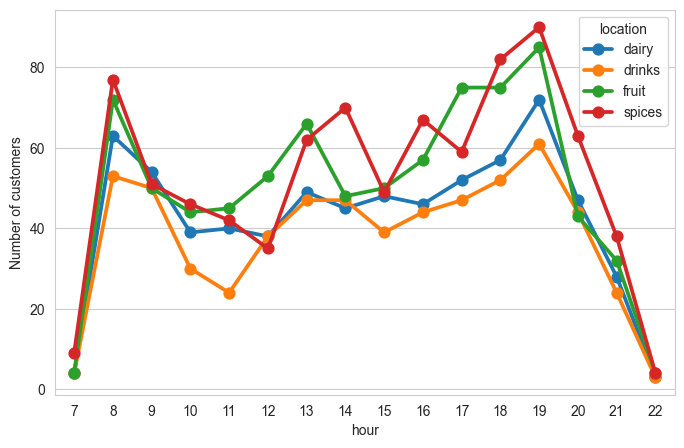

In [10]:
#Nb of customer in each area over time (excluding entrance and checkout)
plt.figure(figsize=(8,5))
df_plot_hour = df_customers.loc[(df_customers['location'] != 'entrance') & (df_customers['location'] != 'checkout'),:].copy()
df_plot_hour = df_plot_hour.groupby(['hour','location']).agg({"customer_id": pd.Series.nunique})
df_plot_hour.reset_index(inplace=True)
sns.pointplot(x='hour',y='customer_id',hue='location',data=df_plot_hour)
plt.ylabel('Number of customers')

# How long a customer is staying in the supermarket?

(6.0, 9.0)

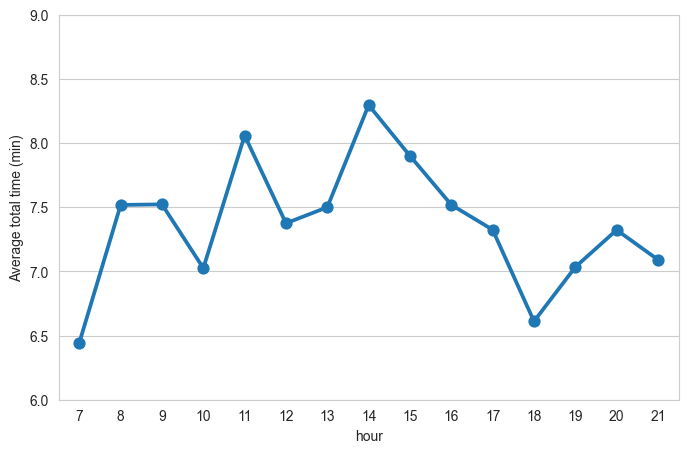

In [11]:
#Time at first state over time
plt.figure(figsize=(8,5))
df_plot_time = df_customers.loc[df_customers['location'] == 'entrance',:].copy()
df_plot_time = df_plot_time.groupby('hour').agg({"total_time": 'mean'})
df_plot_time.reset_index(inplace=True)
sns.pointplot(x='hour',y='total_time',data=df_plot_time)
plt.ylabel('Average total time (min)')
plt.ylim([6,9])

Text(0, 0.5, 'Total time distribution (min)')

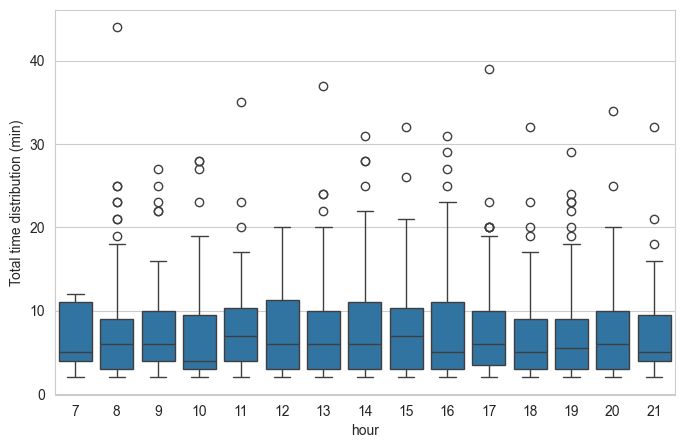

In [12]:
# See the time distribution per hour
plt.figure(figsize=(8,5))
df_plot_time = df_customers.loc[df_customers['location'] == 'entrance',:].copy()
sns.boxplot(data=df_plot_time,y="total_time",x="hour",orient="v")
plt.ylabel('Total time distribution (min)')

# What is the total revenue per hour?

- The estimation will be based on a revenue per minute per section of (4€ for fruit, 3€ for spices, 5€ for dairy and 6€ for drinks )

Text(30.67283950617282, 0.5, 'Revenue per hour')

<Figure size 800x500 with 0 Axes>

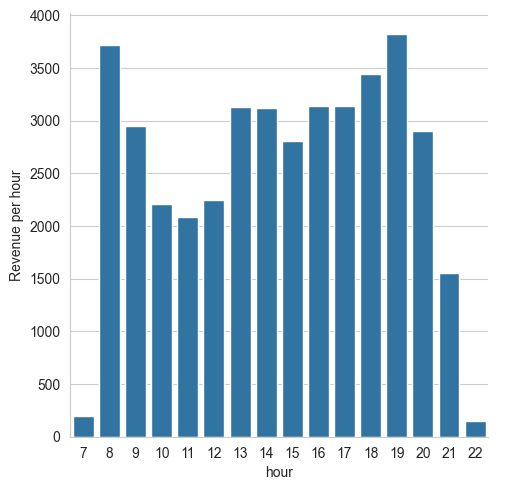

In [13]:
#Revenue per hour
plt.figure(figsize=(8,5))
df_revenue_hour = df_customers.groupby('hour').agg({"price": 'sum'})
df_revenue_hour.reset_index(inplace=True)
sns.catplot(x='hour',y='price',data=df_revenue_hour,kind='bar')
plt.ylabel('Revenue per hour')

# What is the most profitable section?

Text(0.5, 28.999999999999986, 'Section')

<Figure size 800x500 with 0 Axes>

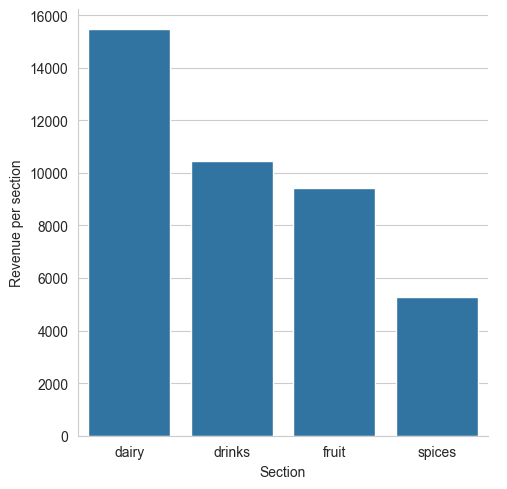

In [14]:
#Revenue per section
plt.figure(figsize=(8,5))
df_revenue_section = df_customers.loc[(df_customers['location'] != 'entrance') & (df_customers['location'] != 'checkout'),:].copy()
df_revenue_section = df_revenue_section.groupby('location').agg({"price": 'sum'})
df_revenue_section.reset_index(inplace=True)
sns.catplot(x='location',y='price',data=df_revenue_section,kind='bar')
plt.ylabel('Revenue per section')
plt.xlabel('Section')